<a href="https://colab.research.google.com/github/EureXaAI/EurexaBook/blob/main/llm_mjx_go1_playground/cbf_safety_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quadruped Robot Collision Avoidance

This notebook demonstrates using control barrier function (CBF) as a safety filter for collision avoidance of a quadruped.

## Installation and Setup
First, let's install the required packages:

In [ ]:
%%capture
!pip install proxsuite==0.6.7
!pip install mujoco mujoco_mjx brax playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

## === If using Colab, please restart kernel so that proxsuite cab be imported properly===

In [ ]:
%load_ext autoreload
%autoreload 2

import jax
import numpy as np
import mediapy
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

os.environ["MUJOCO_GL"] = "egl"

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

## Clone the Repository
Clone the repository containing the simulation environment and navigation code:

In [ ]:
!git clone https://github.com/shaoanlu/llm_mjx_go1_playground.git

fatal: destination path 'llm_mjx_go1_playground' already exists and is not an empty directory.


In [ ]:
%cd llm_mjx_go1_playground

/content/llm_mjx_go1_playground


### Initialize Simulation
Set up the MuJoCo simulation environment:
- Instantiate the `Go1Env` (which load the maze scene XML)
- Configure mujoco camera parameters and rendering options

In [ ]:
# import mujoco after setting MUJOCO_GL to prevent errors in video rendering
import mujoco
from mujoco_playground._src import mjx_env
from typing import List

from src.environment.custom_go1_env import CustomGo1JoystickEnv
from src.environment.env_wrapper import Go1Env
from src.control.controller_factory import ControllerFactory
from src.control.position_controller import PositionController, PositionControllerParams
from src.control.algorithms.polar_coord_control import PolarCoordinateControllerParams
from src.control.algorithms.seq_pos_control import SequentialControllerParams
from src.control.algorithms.mlp import MLPPolicy, MLPPolicyParams
from src.control.algorithms.base import HighLevelCommand

from src.control.models import Simple2DRobot
from src.control.models.simple_robot import Simple2DRobotParams
from src.control.safety_filter import SafetyFilter, SafetyFilterParams
from src.planning.base import FixedWaypointsPlanner
from src.control.state import Go1State

In [ ]:
# Set up the camera
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.lookat[:] = np.array([5.0, 1.5, 1.5])  # Center of object

# Calculate distance using a safe margin
object_size = 10  # Maximum size in X or Y
fov = 45  # Default MuJoCo camera FOV
safe_margin = 1  # Factor to ensure entire object is in view

# Compute required distance using field of view
camera.distance = (object_size / 2) / np.tan(np.radians(fov / 2)) * safe_margin

# Look directly down
camera.azimuth = 90  # No horizontal rotation
camera.elevation = -70  # Downward

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_RANGEFINDER] = True

In [ ]:
# instantiate mujoco Env
rng = jax.random.PRNGKey(0)
mpenv = CustomGo1JoystickEnv(xml_path="xmls/go1_mjx_obstacles_scene.xml")
env = Go1Env(env=mpenv, env_cfg=mpenv.env_cfg)

Downloaded: xmls/assets/calf.stl
Downloaded: xmls/assets/hip.stl
Downloaded: xmls/assets/thigh.stl
Downloaded: xmls/assets/thigh_mirror.stl
Downloaded: xmls/assets/trunk.stl


###  Define Helper Functions

In [ ]:
def sample_pert(rng, env, state, velocity_kick_range=[0.0, 0.0], kick_duration_range=[0.05, 0.2]):
    """
    Random purterbation to the robot
    """
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng


def detect_obstacles(state, lidar_range=list(range(-60, 61, 1))):
    # Read rangefinder sensor data and convert to XY position
    det_points = []
    num_lidar_pnts = len(lidar_range)
    for d, ang in zip(np.array(state.data.sensordata[-num_lidar_pnts:]), lidar_range):
        if d == -1 or abs(d) >= 10:
            continue
        det_points.append((float(d * np.cos(np.deg2rad(ang))), float(d * np.sin(np.deg2rad(ang)))))
    return np.array(det_points)


def preprocess_input_for_safety_filter(state, safety_filter):
    # Convert to Go1State and extract XY vel command
    # note that position returned by rangefinder has origin of current robot position
    state_rel_to_sensor = Go1State.from_mjx_state(state)
    state_rel_to_sensor.position = np.array([0.0, 0.0, state_rel_to_sensor.position[2]])
    return state_rel_to_sensor


# def post_process_safe_command(safe_command, pos_command):
#     # Combine safe XY command and raw yaw command
#     return np.concatenate([safe_command.value, pos_command.value[-1:]])


def plot_detected_obstacles(state, lidar_range=list(range(-60, 61, 1))):
    det_points = []
    det_angles = []

    plt.gca().set_aspect("equal")
    for d, ang in zip(np.array(state.data.sensordata[-len(lidar_range) :]), lidar_range):
        if d == -1 or abs(d) >= 10:
            continue
        # if ang > 90:
        #   continue
        plt.plot([0, float(d * np.cos(np.deg2rad(ang)))], [0, float(d * np.sin(np.deg2rad(ang)))], "-", color="b")
        det_points.append((float(d * np.cos(np.deg2rad(ang))), float(d * np.sin(np.deg2rad(ang)))))
        det_angles.append(ang)
    plt.scatter(np.array(det_points)[:, 0], np.array(det_points)[:, 1], color="g")
    plt.scatter(0, 0, color="r")
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

## Demo: Nagivating a go1 quadruped with safety filter for collision avoidance


### Robot Controllers
1. Waypoint generator
2. High-level position controller that follows waypoints
3. Low-level MLP policy that controls individual joint movements
4. Safety filter that modifies high-level controller's command before feeding it to mlp policy

In [ ]:
# Waypoint planner
planner = FixedWaypointsPlanner(waypoints=[np.array([4, 4]), np.array([9, 0])])

# Low-level MLP
factory = ControllerFactory()
mlp_params = MLPPolicyParams(npy_path="src/control/nn_params/Go1JoystickFlatTerrain")
command_follower = factory.build(params=mlp_params)

# High-level command generator
pc_config = PositionControllerParams(
    primary_controller=SequentialControllerParams(),
    fallback_controller=SequentialControllerParams(),
)
command_generator = PositionController(factory=factory, config=pc_config)

# safety filter
safety_filter = SafetyFilter(
    config=SafetyFilterParams(
        model=Simple2DRobot(Simple2DRobotParams(a=0.41, b=0.27)),
        max_output=(1.5, 0.8),
        min_output=(-1.5, -0.8),
        cbf_alpha=10.0,
        cbf_kappa=10.0,
        cbf_slack_penalty=1e7,
    )
)

## Start Simulation

### Limitation
Since the CBF uses a simple model that has direct control in XY direction. There are gap in terms of
1. Yaw angle control of high-level control not presented in cbf
2. The MLP policy does not track command well in low velocity region (similar to a deadzone)
3. obstacle points are detected in robot coord instead of world coord

Such gaps can lead to deadlock ini some cases where the robot stuck in front of the obstacle.


In [ ]:
rollout: List[mjx_env.State] = []
command_pairs = []
sf_reuslt = []  # for debugging
waypoint_idx: int = 0

_, rng = jax.random.split(rng)
state = env.reset(rng)
waypoints = planner.plan().waypoints
print(f"{waypoints=}")

# start closed-loop sim
for i in tqdm(range(1000)):
    _, rng = jax.random.split(rng)  # this will randomize perturbation
    rng = sample_pert(rng, env, state)

    # calculate control command
    cell_center_offset = 0.5
    target_position = waypoints[waypoint_idx] + cell_center_offset
    pos_command: HighLevelCommand = command_generator.compute_command(state, target_position)

    # detect obstacle points using rangefinder sensor data
    obstacle_positions = detect_obstacles(state)

    # calculate safe command
    # safe_command = pos_command.value
    inp_state = preprocess_input_for_safety_filter(state, safety_filter)
    safe_command: HighLevelCommand = safety_filter.compute_command(
        state=inp_state, nominal_command=pos_command.as_go1_command(), obstacle_positions=obstacle_positions
    )
    state.info["command"] = safe_command.value

    # low-level control
    ctrl = command_follower.control(state.obs["state"])

    # simulator step
    state = env.step(state, ctrl)

    # record
    rollout.append(state)
    command_pairs.append((pos_command.value, safe_command.value))
    sf_reuslt.append(safe_command)

    # check arrival at current waypoint
    if pos_command.info.is_arrived:
        waypoint_idx = min(waypoint_idx + 1, len(waypoints))  # proceed to next waypoint

        # Check if the arrived at the last waypoint
        if waypoint_idx == len(waypoints):
            print("\nRobot arrives at goal position.")
            break

waypoints=[array([4, 4]), array([9, 0])]


 76%|███████▌  | 759/1000 [08:55<02:49,  1.42it/s]


Robot arrives at goal position.


## Results Visualization

In [ ]:
render_every = 5
fps = 3.0 / env.dt / render_every  # 3x realtime
traj = rollout[::render_every]

frames = env.render(traj, camera=camera, scene_option=scene_option, height=480, width=640)
mediapy.show_video(frames, fps=fps, loop=False)

100%|██████████| 152/152 [02:04<00:00,  1.22it/s]


array([[[219, 219, 219],
        [216, 216, 216],
        [211, 211, 211],
        ...,
        [211, 211, 211],
        [216, 216, 216],
        [219, 219, 219]],

       [[219, 219, 219],
        [216, 216, 216],
        [210, 210, 210],
        ...,
        [210, 210, 210],
        [216, 216, 216],
        [219, 219, 219]],

       [[217, 217, 217],
        [214, 214, 214],
        [209, 209, 209],
        ...,
        [209, 209, 209],
        [214, 214, 214],
        [217, 217, 217]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [227, 227, 227],
        [227, 227, 227],
        [227, 227, 227]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [227, 227, 227],
        [227, 227, 227],
        [227, 227, 227]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [227, 227, 227],
        [227, 227, 227],
        [227, 227, 227]]], dtype=uint8)
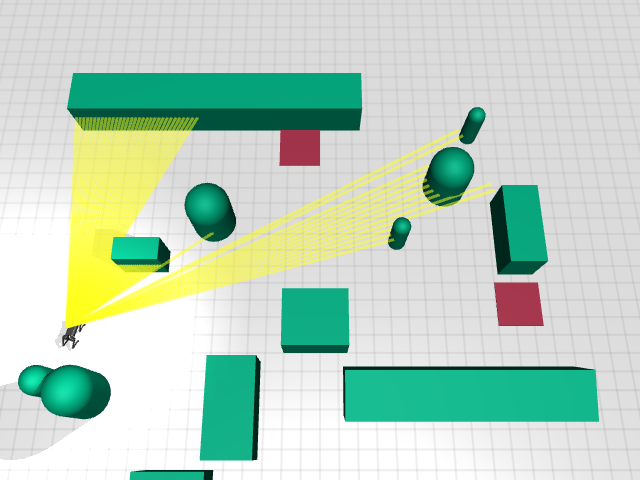

In [ ]:
frames[0]